# Librerías

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from skimage.measure import block_reduce
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Código

### Lectura de los datos

A continuación tenemos las funciones que sirven para leer y escribir los datos. La primera lee los datos a partir de un directorio, que en este caso son *./DevanagariHandwrittenCharacterDataset/Train/* para los del training y *./DevanagariHandwrittenCharacterDataset/Test/* para los del test. Como los datos se encuentran en formato PNG, usamos la función imread de matplotlib para leerlos. La segunda función escribe unos datos dado un nombre de fichero. El formato en el que los escribe es en csv. En nuestro caso los ficheros generados son *train.csv* y *test.csv*.

#### Las siguientes lineas de código escriben en disco, no hace falta volver a ejecutar, los datos ya se encuentran en el CSV.

In [2]:
TRAIN_D='./datos/DevanagariHandwrittenCharacterDataset/Train/'
TEST_D='./datos/DevanagariHandwrittenCharacterDataset/Test/'
TRAIN_CSV='datos/train.csv'
TEST_CSV='datos/test.csv'

    
def readPNG(d):
    X = []
    Y = []
    k = 0
    characters = os.listdir(d)
    for c in characters:
        k = k+1
        path = d+c+'/'
        images = os.listdir(path)
        for i in images:
            x = plt.imread(path+i)[2:-2,2:-2].flatten()
            X.append(x)
            Y.append([k])
    
    ind = np.arange(len(X))
    np.random.shuffle(ind)
    print(len(ind))
    
    return np.array(X)[ind], np.array(Y)[ind]

def writePNG(f, X, Y):
    data = np.hstack((X, Y))
    with open(f, 'w') as file:
        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)


X, Y = readPNG(TRAIN_D)
writePNG(TRAIN_CSV, X, Y)
X, Y = readPNG(TEST_D)
writePNG(TEST_CSV, X, Y)

78200
13800


Función que lee los datos de un CSV, dado el nombre del fichero y el separador de los datos. A continuación leemos los datos de los ficheros CSV de Training y Test.

In [3]:
def readData (filename, separator):
    data = pd.read_csv(filename, sep = separator, low_memory=False)
    values = data.values
    x = values[:, 0:-1]
    y = values[:, -1]

    return x, y


x_train, y_train = readData(TRAIN_CSV, ',')
x_test, y_test = readData(TEST_CSV, ',')

Con la función de matplotlib, imshow podemos ver la representación de cada imagen.

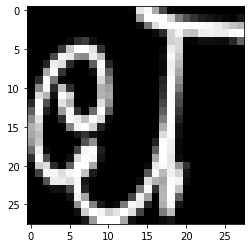

In [4]:
plt.imshow(x_train[0].astype(float).reshape(28, 28), cmap='gray')

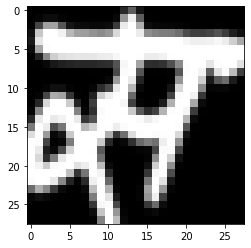

In [5]:
plt.imshow(x_train[4].astype(float).reshape(28, 28), cmap='gray')

### Preprocesamiento de los datos

Función que se encarga de preprocesar los datos. Hay dos tipos de preocesados. En el primero reducimos el número de bloques de la figura haciendo una mendia en cuadrados de $2\times 2$ píxeles. Este procesamiento es opcional. El segundo se encarga de poner el vector que representa a la imagen, unicamente con 1's y 0's, para ellos utilizamos threshold_otsu que nos devuelve cual sería el límite para hacer la distinción entre pixeles 'blancos' y 'negros'.

In [6]:
def preprocess(X, reduce = False):
    p = []
    for x in X:
        if reduce:
            x = block_reduce(x.reshape(28, 28),(2,2),np.mean)
        else:
            x = np.reshape(x,(28, 28))
        threshold = threshold_otsu(x)
        x = np.array([x>=threshold]).astype(int).flatten()
        p.append(x)
    return np.array(p)

Preprocesamos los datos con los dos tipos de procesamiento.

In [7]:
x_train1 = preprocess(x_train)
x_train2 = preprocess(x_train, True)
x_test1 = preprocess(x_test)
x_test2 = preprocess(x_test, True)

Volvemos a mostrar las imagenes con los nuevos procesados, para que se pueda ver que siguen siendo reconocibles.

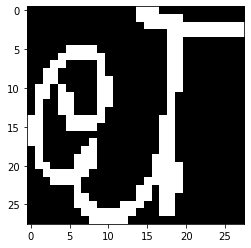

In [8]:
plt.imshow(x_train1[0].astype(float).reshape(28, 28), cmap='gray')

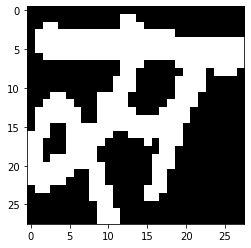

In [9]:
plt.imshow(x_train1[4].astype(float).reshape(28, 28), cmap='gray')

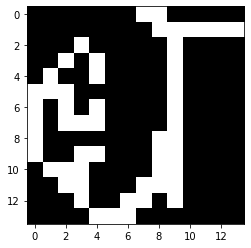

In [10]:
plt.imshow(x_train2[0].astype(float).reshape(14, 14), cmap='gray')

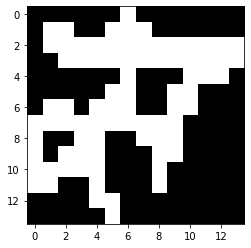

In [11]:
plt.imshow(x_train2[4].astype(float).reshape(14, 14), cmap='gray')

La siguiente función se encarga de buscar los pixeles cuya media de entre todas las muestras, esta o muy cerca del 1 o muy cerca del 0 ('según un umbral'). Debido a esto estos pixeles aportan muy poca información y 'se pueden quitar'. Devuelve un vector con los indices de los atributos 'importantes'.

In [12]:
def reduceDimension(X, threshold = 0):
    index = []
    XT = X.T
    for i in range(len(XT)):
        m = XT[i].mean()
        if m > threshold and 1-m > threshold:
            index.append(i)
            
    return np.array(index) 

Aplicamos el método y vemos como hemos reducido para *x_train1* de 784 a 749, 35 atributos menos, y en el segundo caso de 196 a 189, lo que suponen 7 atributos menos.

In [13]:
i1 = reduceDimension(x_train1, 0.1)
i2 = reduceDimension(x_train2, 0.1)
print(len(i1))
print(len(i2))

749
189


Guardamos las variables aplicandoles la máscara con el vector de indices.

In [14]:
x_train1 = x_train1.T[i1].T
x_train2 = x_train2.T[i2].T

In [15]:
x_test1 = x_test1.T[i1].T
x_test2 = x_test2.T[i2].T

Por último normalizamos los datos.

In [16]:
scaler = StandardScaler()
scaler.fit(x_train1)

x_train1 = scaler.transform(x_train1)
x_test1 = scaler.transform(x_test1)

scaler = StandardScaler()
scaler.fit(x_train2)

x_train2 = scaler.transform(x_train2)
x_test2 = scaler.transform(x_test2)

### Estimación de Hiperparámetros

La siguiente función se encarga de generar un gráfico con los distintos scores con *cv=3* de Random Forest, con *n_parameter* estimadores dentro del rango *rgn*, equiespaciado. Devuelve el rango que obtiene mejores resultados.

In [17]:
def grafNestimators(X, Y, rng, n_parameters):
    output=[]
    step = int((rng[1]-rng[0])/n_parameters)
    parameters = range(rng[0], rng[1]+1, step)
    for n in parameters:
        print(n)
        rf=RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=1)
        score=np.mean(cross_val_score(rf , X, Y, cv=3))
        output.append(score)
    plt.plot(parameters ,output, c='g')
    plt.title('Accuracy media frente a nº de estimadores')
    plt.xlabel('Nº de estimadores')
    plt.ylabel('Accuracy')
    plt.show()
    tmp = max(output)
    index = output.index(tmp)
    if index == len(parameters)-1:
        return [parameters[index-1], parameters[index]]
    else:
        if output[index-1] >= output[index+1]:
            return [parameters[index-1], parameters[index]]
        else:
            return [parameters[index], parameters[index+1]]

100
180
260
340
420
500


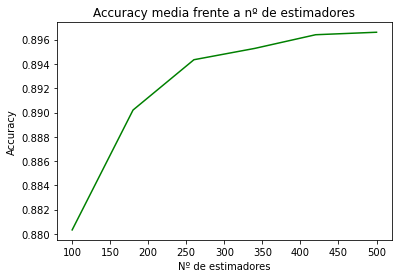

In [18]:
int1 = grafNestimators(x_train2, y_train, [100, 500], 5)

420
436
452
468
484
500


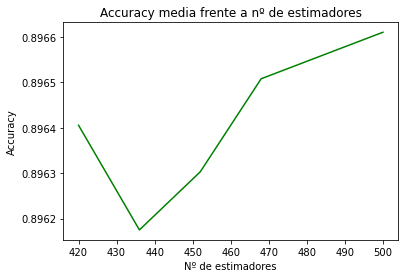

In [19]:
int2 = grafNestimators(x_train2, y_train, int1, 5)

484
488
492
496
500


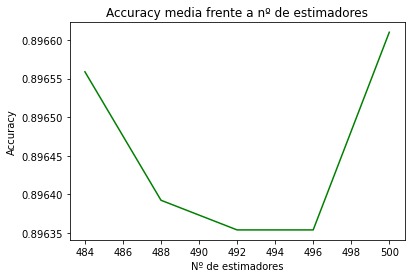

[496, 500]

In [20]:
grafNestimators(x_train2, y_train, int2, 4)

La siguiente función se encarga de generar un gráfico con los distintos scores con *cv=2* de Multilayer Perceptron, con *n_parameter* como número de neuronas por capa, dentro del rango *rgn*, equiespaciado. Devuelve el rango que obtiene mejores resultados.

In [21]:
def grafPestimators(X, Y, rng, n_parameters):
    output=[]
    step = int((rng[1]-rng[0])/n_parameters)
    parameters = range(rng[0], rng[1]+1, step)
    for p in parameters:
        print(p)
        mlp = MLPClassifier(hidden_layer_sizes= (p, p), activation='tanh', max_iter = 1000, random_state=1)
        score=np.mean(cross_val_score(mlp , X, Y, cv=2, n_jobs=-1))
        output.append(score)
    plt.plot(parameters ,output, c='g')
    plt.title('Accuracy media frente a nº de neuronas')
    plt.xlabel('Nº de neuronas por capa')
    plt.ylabel('Accuracy')
    plt.show()
    tmp = max(output)
    index = output.index(tmp)
    if index == len(parameters)-1:
        return [parameters[index-1], parameters[index]]
    else:
        if output[index-1] >= output[index+1]:
            return [parameters[index-1], parameters[index]]
        else:
            return [parameters[index], parameters[index+1]]

50
55
60
65
70
75


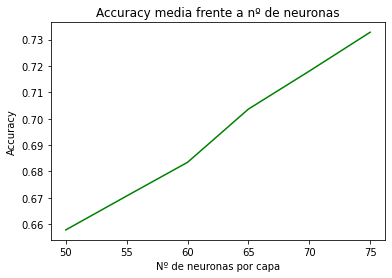

In [22]:
int4 = grafPestimators(x_train2, y_train, [50, 75], 5)

70
71
72
73
74
75


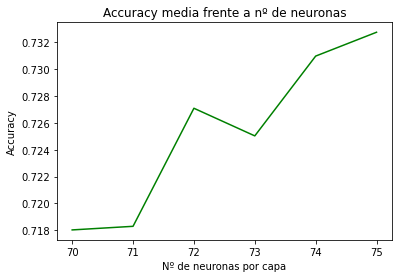

[74, 75]

In [23]:
grafPestimators(x_train2, y_train, int4, 5)

A continuación vamos a hacer una pequeña comparación entre el método MLP con *early_stopping* y sin el.

In [24]:
mlp = MLPClassifier(hidden_layer_sizes= (75, 75), activation='tanh', max_iter = 1000, random_state=1)
score1=np.mean(cross_val_score(mlp , x_train2, y_train, cv=2, n_jobs=-1))

mlp_early = MLPClassifier(hidden_layer_sizes= (75, 75), early_stopping=True, activation='tanh', max_iter = 1000, random_state=1)
score2=np.mean(cross_val_score(mlp , x_train2, y_train, cv=2, n_jobs=-1))

In [25]:
score1, score2

(0.7327587099545132, 0.7327587099545132)

La siguientes funciónes se encarga de generar un gráfico con los distintos scores con *cv=5* de Regresión Logística, con *n_parameter* alphas dentro del rango *rgn*,logarítmico "equiespaciado". Devuelve el rango que obtiene mejores resultados. La primera realiza esto con Lasso y la segunda con Ridge.

In [26]:
def grafAlphaestimatorsl1(X, Y, rng, n_parameters):
    output = []
    parameters = np.logspace(rng[0], rng[1], n_parameters)
    for a in parameters:
        print(a)
        l=SGDClassifier(max_iter=1000, tol=1e-3, loss='log', penalty='l1', alpha=a, n_jobs=-1, random_state=1)
        score=np.mean(cross_val_score(l , X, Y, cv=5))
        output.append(score)
    plt.plot(parameters ,output, c='g')
    plt.title(r'Accuracy media frente al valor de $\alpha$')
    plt.xlabel(r'Valor de $\alpha$')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.show()
    tmp = max(output)
    index = output.index(tmp)
    if index == len(parameters)-1:
        return [parameters[index-1], parameters[index]]
    else:
        if output[index-1] >= output[index+1]:
            return [parameters[index-1], parameters[index]]
        else:
            return [parameters[index], parameters[index+1]]

In [27]:
def grafAlphaestimatorsl2(X, Y, rng, n_parameters):
    output = []
    parameters = np.logspace(rng[0], rng[1], n_parameters)
    for a in parameters:
        print(a)
        l=SGDClassifier(max_iter=1000, tol=1e-3, loss='log', penalty='l2', alpha=a, n_jobs=-1, random_state=1)
        score=np.mean(cross_val_score(l , X, Y, cv=5))
        output.append(score)
    plt.plot(parameters ,output, c='g')
    plt.title(r'Accuracy media frente al valor de $\alpha$')
    plt.xlabel(r'Valor de $\alpha$')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.show()
    tmp = max(output)
    index = output.index(tmp)
    if index == len(parameters)-1:
        return [parameters[index-1], parameters[index]]
    else:
        if output[index-1] >= output[index+1]:
            return [parameters[index-1], parameters[index]]
        else:
            return [parameters[index], parameters[index+1]]

1e-05
0.0001
0.001
0.01
0.1


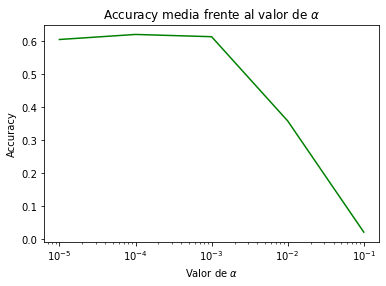

[0.0001, 0.001]

In [29]:
grafAlphaestimatorsl1(x_train2, y_train, [-5, -1], 5)

1e-05
6.309573444801929e-05
0.00039810717055349735
0.002511886431509582
0.01584893192461114
0.1


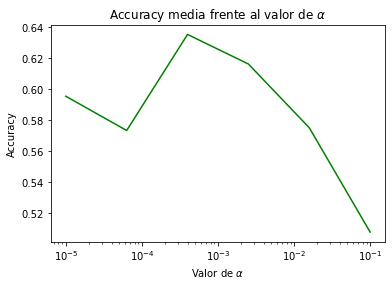

[0.00039810717055349735, 0.002511886431509582]

In [30]:
grafAlphaestimatorsl2(x_train2, y_train, [-5, -1], 6)

### Entrenamiento de los modelos

In [31]:
rl1 = SGDClassifier(max_iter=2000, tol=1e-3, loss='log', penalty='l1', alpha=0.0001, n_jobs=-1, random_state=1)
rl2 = SGDClassifier(max_iter=2000, tol=1e-3, loss='log', penalty='l1', alpha=0.0001, n_jobs=-1, random_state=1)
rl3 = SGDClassifier(max_iter=2000, tol=1e-3, loss='log', penalty='l2', alpha=0.00039, n_jobs=-1, random_state=1)
rl4 = SGDClassifier(max_iter=2000, tol=1e-3, loss='log', penalty='l2', alpha=0.00039, n_jobs=-1, random_state=1)
mlp1 = MLPClassifier(hidden_layer_sizes= (75, 75), early_stopping=True, activation='tanh', max_iter = 1000, random_state=1)
mlp2 = MLPClassifier(hidden_layer_sizes= (75, 75), early_stopping=True, activation='tanh', max_iter = 1000, random_state=1)
rf1 = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1)
rf2 = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1)

rl1.fit(x_train1, y_train)
rl2.fit(x_train2, y_train)
rl3.fit(x_train1, y_train)
rl4.fit(x_train2, y_train)
mlp1.fit(x_train1, y_train)
mlp2.fit(x_train2, y_train)
rf1.fit(x_train1, y_train)
rf2.fit(x_train2, y_train)

RandomForestClassifier(n_estimators=496, n_jobs=-1, random_state=1)

### Resultados

La siguiente función imprime los resultados obtenidos y la matriz de confusión

In [52]:
def informeResultados(model, xt, yt, xtrain, ytrain):
    print("El accuracy obtenido por este modelo sobre el conjunto de test es :" + str(model.score(xt, yt)))
    print("El accuracy obtenido por este modelo sobre el conjunto de training es :" + str(model.score(xtrain, ytrain)))
    cf_matrix = confusion_matrix(yt, model.predict(xt))

    ax = sns.heatmap(cf_matrix, cmap='viridis')

    ax.set_title('Matriz de Confusión del conjunto Test\n\n');
    ax.set_xlabel('\nPredicciones')
    ax.set_ylabel('Valores reales ');

Imprimimos los resultados con cada modelo entrenado:

El accuracy obtenido por este modelo sobre el conjunto de test es :0.6504819189796363
El accuracy obtenido por este modelo sobre el conjunto de training es :0.6970677374390977


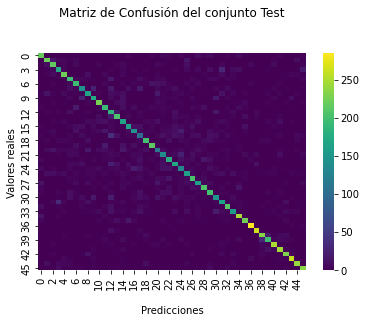

In [53]:
informeResultados(rl1, x_test1, y_test, x_train1, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.6504819189796363
El accuracy obtenido por este modelo sobre el conjunto de training es :0.6970677374390977


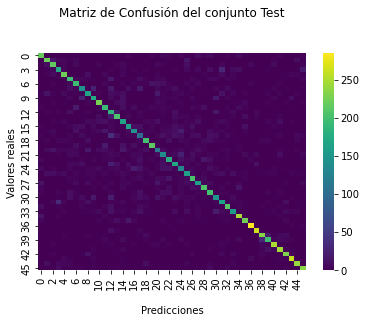

In [54]:
informeResultados(rl1, x_test1, y_test, x_train1, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.6356982390028263
El accuracy obtenido por este modelo sobre el conjunto de training es :0.6488190386066318


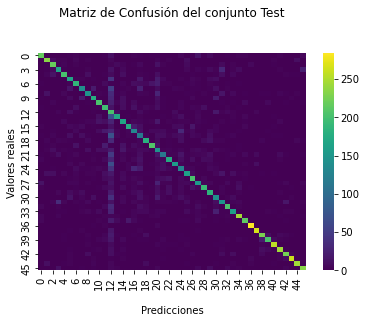

In [55]:
informeResultados(rl2, x_test2, y_test, x_train2, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.6770780491339952
El accuracy obtenido por este modelo sobre el conjunto de training es :0.6810956661849896


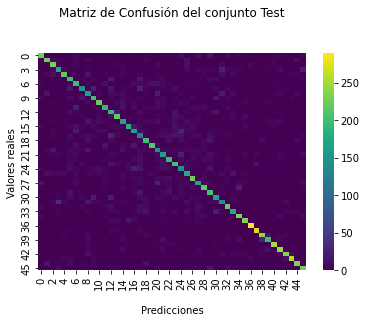

In [56]:
informeResultados(rl3, x_test1, y_test, x_train1, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.6433074860497138
El accuracy obtenido por este modelo sobre el conjunto de training es :0.6461463701581862


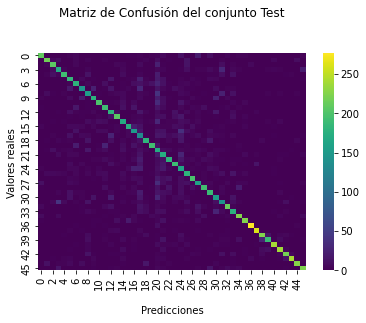

In [57]:
informeResultados(rl4, x_test2, y_test, x_train2, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.8063627799115878
El accuracy obtenido por este modelo sobre el conjunto de training es :0.9027992685328456


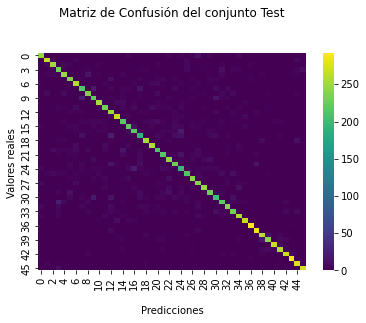

In [58]:
informeResultados(mlp1, x_test1, y_test, x_train1, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.8215088049858685
El accuracy obtenido por este modelo sobre el conjunto de training es :0.8973132648755099


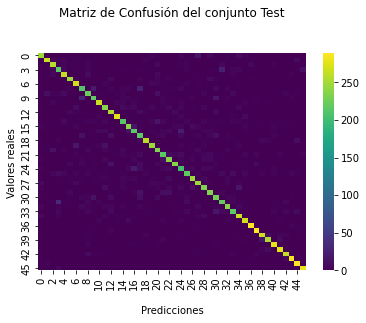

In [59]:
informeResultados(mlp2, x_test2, y_test, x_train2, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.9108631060221756
El accuracy obtenido por este modelo sobre el conjunto de training es :1.0


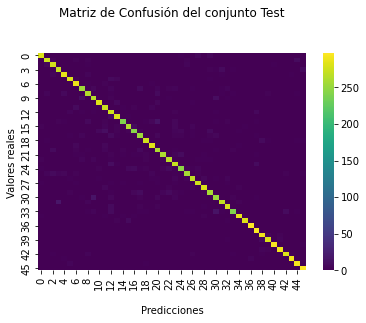

In [60]:
informeResultados(rf1, x_test1, y_test, x_train1, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.9113703891586347
El accuracy obtenido por este modelo sobre el conjunto de training es :1.0


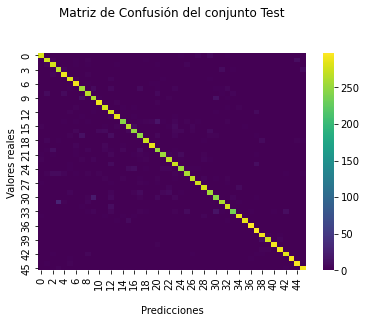

In [61]:
informeResultados(rf2, x_test2, y_test, x_train2, y_train)

Debido a los resultados obtenidos en Regresión Logística, hemos intentados probar, a ver si con datos polinómicos hasta grado 4 (sin multiplicaciones cruzadas para no añadir demasiados términos que aumenten mucho el coste computacional), obtenemos mejores resultados.

In [43]:
def polynomial(data, grado):
    nuevodata = data.copy()
    for n in range(2,grado+1):
        nuevodata = np.hstack((nuevodata, data**n))
    return nuevodata

In [46]:
xt2_quad = polynomial(x_train2, 4)
xtest2_quad = polynomial(x_test2, 4)

In [48]:
lasso = SGDClassifier(max_iter=2000, tol=1e-3, loss='log', penalty='l1', alpha=0.0001, n_jobs=-1, random_state=1)
ridge = SGDClassifier(max_iter=2000, tol=1e-3, loss='log', penalty='l2', alpha=0.00039, n_jobs=-1, random_state=1)

print('Lasso')
lasso.fit(xt2_quad, y_train)
print('Ridge')
ridge.fit(xt2_quad, y_train)

Lasso


C:\Users\ignan\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Ridge


SGDClassifier(alpha=0.00039, loss='log', max_iter=2000, n_jobs=-1,
              random_state=1)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.5904051018189724
El accuracy obtenido por este modelo sobre el conjunto de training es :0.6106088313149785


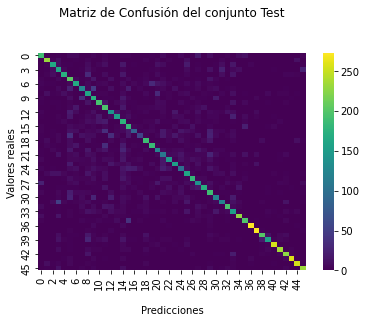

In [49]:
informeResultados(lasso, xtest2_quad, y_test, xt2_quad, y_train)

El accuracy obtenido por este modelo sobre el conjunto de test es :0.6130154359011523
El accuracy obtenido por este modelo sobre el conjunto de training es :0.6220284146856098


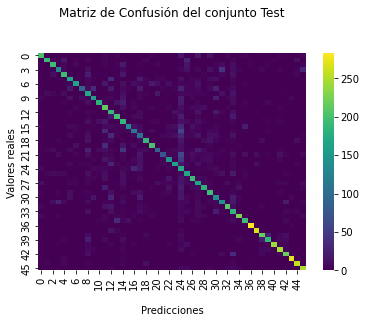

In [50]:
informeResultados(ridge, xtest2_quad, y_test, xt2_quad, y_train)